# Example of Track Reconstruction from Graph Output

In [1]:
%load_ext autoreload
%autoreload 2

# System imports
import os
import sys
import yaml
import logging

# External imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

# import seaborn as sns
import torch

import warnings

warnings.filterwarnings("ignore")
sys.path.append("../../..")

from notebooks.ITk.utils import *
from onetrack import TrackingData
from onetrack.file_utils import list_files
device = "cuda" if torch.cuda.is_available() else "cpu"
logging.basicConfig(level=logging.INFO)

## Implementation

In [2]:
# Read yaml config 
with open("tracking_config.yaml", "r") as f:
    config = yaml.safe_load(f)

In [3]:
# Load in files
files = list_files(os.path.join(config["graph_input_dir"], "train"))[:10]

In [4]:
sample = torch.load(files[0], map_location="cpu")

In [4]:
# Build TrackingData object
tracking_data = TrackingData(files)

INFO:root:Loading files


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Building events


  0%|          | 0/10 [00:00<?, ?it/s]

## Example usage

Sanity check the graph:

In [9]:
tracking_data.build_candidates(building_method="CC", sanity_check=True)

INFO:root:Building candidates with sanity check: True


  0%|          | 0/10 [00:00<?, ?it/s]

In [10]:
tracking_data.evaluate_candidates(evaluation_method="matching")

INFO:root:Evaluating candidates


  0%|          | 0/10 [00:00<?, ?it/s]

{'building_method': 'CC', 'evaluation_method': 'matching', 'eff': 0.9780466386964581, 'single_eff': 0.978729632159235, 'fr': 8.520790729382721e-05, 'dup': 0.14579072937968643}
n_true_tracks: 10249, n_reco_tracks: 11736, n_matched_particles: 10024, n_matched_tracks: 11735, n_duplicated_tracks: 1711


Now run real pipeline:

In [69]:
tracking_data.build_candidates(building_method="CC", score_cut = 0.85)

INFO:root:Building candidates with sanity check: False


  0%|          | 0/10 [00:00<?, ?it/s]

In [70]:
matching_config = {
    "min_hits_truth": 9,
    "min_hits_reco": 5,
    "frac_reco_matched": 0.5,
    "frac_truth_matched": 0.5,
}

In [71]:
tracking_data.evaluate_candidates(evaluation_method="matching", **matching_config)

INFO:root:Evaluating candidates


  0%|          | 0/10 [00:00<?, ?it/s]

{'building_method': 'CC', 'evaluation_method': 'matching', 'eff': 0.9417504146746024, 'single_eff': 0.945262952483169, 'fr': 0.005251346499102305, 'dup': 0.07136445242369839}
n_true_tracks: 10249, n_reco_tracks: 22280, n_matched_particles: 9652, n_matched_tracks: 22163, n_duplicated_tracks: 1590


## Resolution of Track Parameters

In [9]:
def conformal_mapping(x, y, z):
    """
    x, y, z: np.array([])
    return: 
    """
    # ref. 10.1016/0168-9002(88)90722-X
    r = x**2 + y**2
    u = x/r
    v = y/r
    # assuming the imapact parameter is small
    # the v = 1/(2b) - u x a/b - u^2 x epsilon x (R/b)^3
    pp, res1, _, _, _ = np.polyfit(u, v, 2, full=True)
    b = 0.5/pp[2]
    a = -pp[1]*b
    R = np.sqrt(a**2 + b**2)
    e = -pp[0] / (R/b)**3 # approximately equals to d0
    magnetic_field = 2.0
    pT = 0.3*magnetic_field*R/1000 # in GeV
    # print(a, b, R, e, pT)

    p_rz, res2, _, _, _ = np.polyfit(np.sqrt(r), z, 2, full=True)
    pp_rz = np.poly1d(p_rz)
    z0 = pp_rz(abs(e))

    r3 = np.sqrt(r + z**2)
    p_zr, res3, _, _, _ = np.polyfit(r3, z, 2, full=True)
    cos_val = p_zr[0]*z0 + p_zr[1]
    theta = np.arccos(cos_val)
    eta = -np.log(np.tan(theta/2.))
    phi = np.arctan2(b, a)

    return e, z0, eta, phi, pT, res1, res2, res3

In [13]:
tracking_data[0].candidates.evaluation["candidates"]

,hit_id,track_id,x,y,z,cluster_index_1,cluster_index_2,particle_id,hardware,cluster_x_1,...,status,charge,pdgId,pass,vProdNIn,vProdNOut,vProdStatus,vProdBarcode,is_fiducial,is_matched
0,0,0,-41.8120,-5.93617,-263.00,0.0,-1.0,6.752000e+10,PIXEL,-41.8120,...,1.0,-1.0,-211.0,NO,1.0,2.0,0.0,-1096.0,False,True
1,15,15,-35.9003,-7.22228,-263.00,15.0,-1.0,6.762000e+10,PIXEL,-35.9003,...,1.0,1.0,2212.0,YES,37.0,82.0,0.0,-338.0,True,True
2,21,21,-55.1714,-9.88259,-263.00,21.0,-1.0,6.769000e+10,PIXEL,-55.1714,...,1.0,1.0,211.0,NO,13.0,19.0,0.0,-306.0,False,True
3,22,22,-47.5729,-21.21410,-263.00,22.0,-1.0,6.060000e+02,PIXEL,-47.5729,...,1.0,1.0,211.0,YES,15.0,33.0,0.0,-431.0,True,True
4,28,28,-34.6797,-12.03040,-263.00,28.0,-1.0,6.901000e+10,PIXEL,-34.6797,...,1.0,-1.0,-211.0,NO,1.0,3.0,0.0,-474.0,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27860,321232,113048,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
27861,321233,91293,519.5110,-447.18100,2839.25,449745.0,449769.0,6.788000e+10,STRIP,518.3820,...,1.0,1.0,2212.0,YES,19.0,36.0,0.0,-592.0,True,True
27862,321318,82388,822.4670,-378.89400,2839.25,450002.0,450015.0,6.863000e+10,STRIP,806.2730,...,1.0,1.0,211.0,YES,5.0,8.0,0.0,-138.0,True,True
27863,321363,91788,822.6300,-300.09600,2839.25,450094.0,450109.0,6.783000e+10,STRIP,833.7120,...,1.0,-1.0,-321.0,YES,1.0,2.0,0.0,-1052.0,True,True


In [71]:
event = tracking_data[0]
tracks = event.candidates.evaluation["candidates"]
particles = event.event_truth.particles
tracks = tracks[tracks.is_matched]

In [72]:
# Append count number of track_ids to each track row
tracks = tracks.merge(tracks.groupby("track_id").count().hit_id, on="track_id")
tracks.rename(columns={"hit_id_y": "n_hits"}, inplace=True)
tracks = tracks[tracks.n_hits >= 5]

In [202]:
eta_error, pt_error = [], []
track_eta_list, track_pt_list = [], []
truth_eta_list, truth_pt_list = [], []
res_list = []

for track_id in tqdm(tracks.track_id.unique()):
    try:
        track = tracks[tracks.track_id == track_id]
        x, y, z = track.x.values, track.y.values, track.z.values
        e, z0, eta, phi, pT, res1, res2, res3 = conformal_mapping(x, y, z)
        
        if pT > 10:
            continue

        eta_error.append(eta - track.eta.mean())
        pt_error.append(pT / (track.pt.mean()/1000))
        track_eta_list.append(eta)
        track_pt_list.append(pT)
        truth_eta_list.append(track.eta.mean())
        truth_pt_list.append(track.pt.mean()/1000)
        res_list.append(res1 + res2 + res3)

    except:
        pass

eta_error, pt_error = np.array(eta_error), np.array(pt_error)
eta_error, pt_error = eta_error[~np.isnan(eta_error)], pt_error[~np.isnan(pt_error)]
track_eta_list, track_pt_list = np.array(track_eta_list), np.array(track_pt_list)
track_eta_list, track_pt_list = track_eta_list[~np.isnan(track_eta_list)], track_pt_list[~np.isnan(track_pt_list)]
truth_eta_list, truth_pt_list = np.array(truth_eta_list), np.array(truth_pt_list)
truth_eta_list, truth_pt_list = truth_eta_list[~np.isnan(truth_eta_list)], truth_pt_list[~np.isnan(truth_pt_list)]
res_list = np.array(res_list)
res_list = res_list[~np.isnan(res_list)]

print(f"Mapped {len(eta_error)} tracks")
print(f"eta error: {np.mean(eta_error)} +/- {np.std(eta_error)}")
print(f"pt error: {np.mean(pt_error)} +/- {np.std(pt_error)}")
print(f"Residual: {np.mean(res_list)} +/- {np.std(res_list)}")


100%|██████████| 2415/2415 [00:02<00:00, 923.97it/s] 


Mapped 2132 tracks
eta error: 0.0001554933339970343 +/- 0.08786549861323548
pt error: 1.304236370979597 +/- 1.0346854062947457
Residual: 57.993764872873804 +/- 195.8772799789682


Text(0.95, 0.95, '$\\eta$ error\n(truth eta - track eta)\n0.00 +/- 0.09')

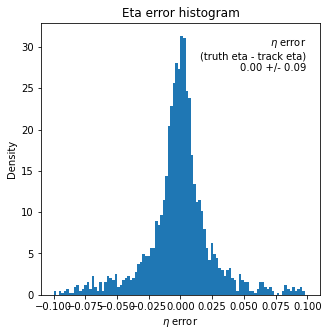

In [191]:
# Plot eta error histogram
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.hist(eta_error, bins=100, density=True, range=(-0.1, 0.1))
ax.set_xlabel("$\eta$ error")
ax.set_ylabel("Density")
ax.set_title("Eta error histogram")

# Add mean and std to plot in a box in the top right corner
ax.text(0.95, 0.95, f"$\eta$ error\n(truth eta - track eta)\n{np.mean(eta_error):.2f} +/- {np.std(eta_error):.2f}",
        horizontalalignment='right',
        verticalalignment='top',
        transform=ax.transAxes)

Text(0.05, 0.95, '$p_T$ error\n(track pT/truth pT):\n1.30 +/- 1.03 GeV')

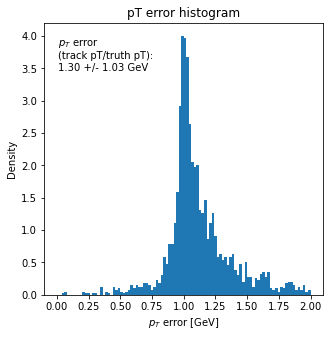

In [189]:
# Plot pt error histogram
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.hist(pt_error, bins=100, density=True, range=(0, 2))
ax.set_xlabel("$p_T$ error [GeV]")
ax.set_ylabel("Density")
ax.set_title("pT error histogram")

# Add mean and std to plot in a box in the top right corner
ax.text(0.05, 0.95, f"$p_T$ error\n(track pT/truth pT):\n{np.mean(pt_error):.2f} +/- {np.std(pt_error):.2f} GeV",
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes)

Text(0.5, 1.0, 'Eta histogram')

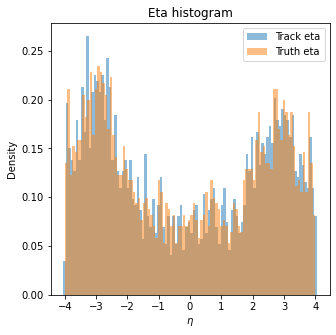

In [162]:
# Plot histogram comparing truth and track eta lists
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.hist(track_eta_list, bins=100, density=True, label="Track eta", alpha=0.5)
ax.hist(truth_eta_list, bins=100, density=True, label="Truth eta", alpha=0.5)
ax.legend()
ax.set_xlabel("$\eta$")
ax.set_ylabel("Density")
ax.set_title("Eta histogram")

Text(0.5, 1.0, 'pT histogram')

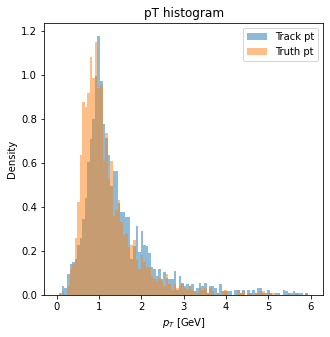

In [163]:
# Plot histogram comparing truth and track pt  lists
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.hist(track_pt_list, bins=100, density=True, label="Track pt", alpha=0.5, range=(0, 6))
ax.hist(truth_pt_list, bins=100, density=True, label="Truth pt", alpha=0.5, range=(0, 6))
ax.legend()
ax.set_xlabel("$p_T$ [GeV]")
ax.set_ylabel("Density")
ax.set_title("pT histogram")

Text(0.5, 1.0, 'Residual histogram')

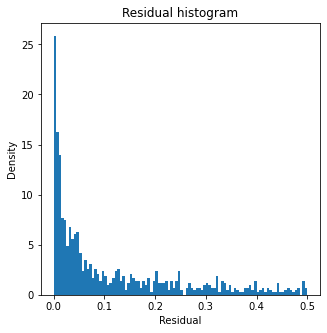

In [203]:
# Plot residual histogram
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.hist(res_list, bins=100, density=True, range=(0, 0.5))
ax.set_xlabel("Residual")
ax.set_ylabel("Density")
ax.set_title("Residual histogram")

## Cutting Fakes with pT

In [72]:
tracking_data.fit_candidates()

100%|██████████| 10/10 [00:13<00:00,  1.36s/it]


Text(0.5, 1.0, 'Residual histogram')

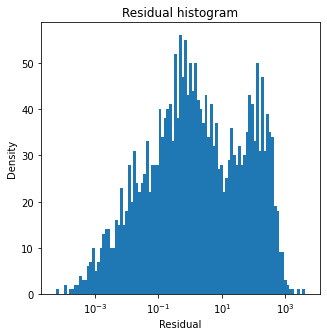

In [ ]:
# Plot hist of sum res1, res2, res3
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
total_res = event.candidates.fit_parameters.res1 + event.candidates.fit_parameters.res2 + event.candidates.fit_parameters.res3
total_res = total_res[~np.isnan(total_res)]
res_bins = np.logspace(np.log10(total_res.min()), np.log10(total_res.max()), 100)
res_hist, res_bins = np.histogram(total_res, bins=res_bins)
ax.bar(res_bins[:-1], res_hist, width=res_bins[1:]-res_bins[:-1])
# Set to logspace
ax.set_xscale("log")
ax.set_xlabel("Residual")
ax.set_ylabel("Density")
ax.set_title("Residual histogram")


In [50]:
total_res = event.candidates.fit_parameters.res1 + event.candidates.fit_parameters.res2 + event.candidates.fit_parameters.res3
low_residual_candidates = event.candidates.fit_parameters[total_res < 100]

In [51]:
low_residual_candidates

,track_id,e,z0,eta,phi,pT,res1,res2,res3
0,12,0.227696,-22.309254,-2.294701,1.990126,1.278550,1.342026e-09,32.638852,0.047556
1,13,-0.120298,85.819527,-2.705192,1.917487,1.498651,1.558753e-10,0.865798,0.007856
2,14,-0.069164,-50.118190,-2.240572,-1.368664,2.359360,1.379620e-11,0.036129,0.001407
3,25,-0.315134,-20.331477,-2.506457,-1.299043,0.590660,3.810552e-11,0.085258,0.000044
4,27,-0.212814,-50.934883,-2.132350,1.764345,0.977785,1.370508e-10,0.148253,0.001041
...,...,...,...,...,...,...,...,...,...
2288,262319,-171.670980,573.952719,1.868385,-2.887860,1.228986,1.094554e-11,38.483229,0.297487
2289,262372,12.469112,110.524130,1.631697,-3.019174,2.547177,5.914507e-11,11.098627,0.168778
2290,263854,-15.871272,245.387690,1.795843,1.242414,2.433137,7.602895e-12,10.929319,0.090255
2291,263887,31.090906,21.172250,2.281659,-1.724974,7.790283,1.371247e-12,43.153668,0.159644


In [57]:
event.candidates.get_df()

,hit_id,track_id
0,0,0
1,1,1
2,2,2
3,3,3
4,4,4
...,...,...
301044,301044,277731
301045,301045,277732
301046,301046,277733
301047,301047,277734


In [63]:
low_residual_hits = event.candidates.get_df().merge(low_residual_candidates, on="track_id", how="inner")

In [64]:
low_residual_hits.hit_id.values

array([    12,     63,  20313, ..., 292310, 296476, 300750])

In [73]:
tracking_data.evaluate_candidates(evaluation_method="matching", **matching_config)

INFO:root:Evaluating candidates


  0%|          | 0/10 [00:00<?, ?it/s]

{'building_method': 'CC', 'evaluation_method': 'matching', 'eff': 0.9417504146746024, 'single_eff': 0.945262952483169, 'fr': 0.005251346499102305, 'dup': 0.07136445242369839}
n_true_tracks: 10249, n_reco_tracks: 22280, n_matched_particles: 9652, n_matched_tracks: 22163, n_duplicated_tracks: 1590


In [67]:
max_res = 100

for event in tracking_data:
    total_res = event.candidates.fit_parameters.res1 + event.candidates.fit_parameters.res2 + event.candidates.fit_parameters.res3
    low_residual_candidates = event.candidates.fit_parameters[total_res < max_res]
    low_residual_hits = event.candidates.get_df().merge(low_residual_candidates, on="track_id", how="inner")
    event.candidates.hit_ids = low_residual_hits.hit_id.values
    event.candidates.track_ids = low_residual_hits.track_id.values

In [88]:
min_pt = 1.5

for event in tracking_data:
    high_pt_candidates = event.candidates.fit_parameters[event.candidates.fit_parameters.pT > min_pt]
    high_pt_hits = event.candidates.get_df().merge(high_pt_candidates, on="track_id", how="inner")
    event.candidates.hit_ids = high_pt_hits.hit_id.values
    event.candidates.track_ids = high_pt_hits.track_id.values